# Teoría de la Información y la Codificación
## Tarea: Códigos QR


# Autor: 

Rellene la siguiente información:

 - Estudiante (nombre y apellidos): Jorge Gangoso Klöck
 - DNI/NIE/Pasaporte: 49398653N
 - Grupo: 1
 - Curso académico: 2021-2022 



__Yo, como estudiante de la asignatura, aseguro que la elaboración de estos ejercicios ha sido realizada de forma individual, sin incurrir en copias parciales o totales de código fuente o documentación, y acepto las repercusiones que conllevaría si esto no fuese así.__


# Respuestas a las cuestiones teóricas:


Escribir aquí las respuestas a las cuestiones teóricas. De ser necesario incluir material adicional (imágenes, tablas), hágalo conforme al tutorial de Jupyter Notebook facilitado en la primera semana del curso.

In [1]:

#imports
import numpy as np


# Import de PyPlot para visualización
import matplotlib.pyplot as plt

In [2]:

# Funciones auxiliares


# Función para el cálculo de tablas de logaritmos y antilogaritmos
# Es una función auxiliar utilizada para acelerar la multiplicación de elementos en un cuerpo GF(256)
# No tiene mayor interés para la práctica, salvo conocer que se usa para facilitar el cálculo comentado
def logTable(n=256):
    table= [1]
    antitable= [None]*n
    value= int(285)
    for i in range(1, n):
        data= table[i-1]*2
        if (data >= 256):
            data= data^value
        table.append( data )
    
    for i in range(1, n):
        found=False
        k=0
        while (not found):
            if (table[k] == i):
                found= True
            else:
                k= k+1
        antitable[i]= k
    return (table,antitable)


# Dados dos valores x e y del cuerpo GF(256), devuelve el elemento del cuerpo
# resultante de la operación x*y
def gf_mul(x,y):
    r= logTable()
    logt= r[0]
    alogt= r[1]
    
    xa= alogt[x]
    ya= alogt[y]
    r= np.mod(xa+ya, 255)
    return logt[r]


# Devuelve el polinomio generador
def GeneratorPoly():
    r= logTable()
    logt= r[0]
    alogt= r[1]
    # Polinomio generador: α0x7 + α87x6 + α229x5 + α146x4 + α149x3 + α238x2 + α102x + α21
    return [1, logt[87], logt[229], logt[146], logt[149], logt[238], logt[102], logt[21]]


# Función que implementa la división entre polinomios.
# Dado un polinomio dividendo, representado como un array de la forma:
#     dividend[0]*x^k + dividend[1]*x^(k-1) + ... + dividend[k-2]*x + dividend[k-1]
# y dado un polinomio divisor:
#     divisor[0]*x^n + divisor[1]*x^(n-1) + ... + divisor[n-2]*x + dividend[n-1]
#
# la función devuelve el cociente y el resto de la operación dividev/divisor
#
# ENTRADAS:
#  - dividend: array de los coeficientes del polinomio dividendo. Deben ser enteros entre 0 y 255,
#               codificando los elementos del cuerpo GF(256)
#  - divisor: array de los coeficientes del polinomio divisor. Deben ser enteros entre 0 y 255,
#               codificando los elementos del cuerpo GF(256)
#
# SALIDAS:
#  - quotient: array de los coeficientes del polinomio del cociente de dividend/divisor. Son enteros entre 0 y 255,
#               codificando los elementos del cuerpo GF(256)
#  - remaining: array de los coeficientes del polinomio del resto de dividend/divisor. Son enteros entre 0 y 255,
#               codificando los elementos del cuerpo GF(256)
# NOTA: Código obtenido de: https://en.wikiversity.org/wiki/Reed%E2%80%93Solomon_codes_for_coders
def gf_poly_div(dividend, divisor):

    msg_out = list(dividend) # Copy the dividend
    #normalizer = divisor[0] # precomputing for performance
    for i in range(0, len(dividend) - (len(divisor)-1)):
        #msg_out[i] /= normalizer # for general polynomial division (when polynomials are non-monic), the usual way of using
                                  # synthetic division is to divide the divisor g(x) with its leading coefficient, but not needed here.
        coef = msg_out[i] # precaching
        if coef != 0: # log(0) is undefined, so we need to avoid that case explicitly (and it's also a good optimization).
            for j in range(1, len(divisor)): # in synthetic division, we always skip the first coefficient of the divisior,
                                              # because it's only used to normalize the dividend coefficient
                if divisor[j] != 0: # log(0) is undefined
                    msg_out[i + j] ^= gf_mul(divisor[j], coef) # equivalent to the more mathematically correct
                                                               # (but xoring directly is faster): msg_out[i + j] += -divisor[j] * coef

    # The resulting msg_out contains both the quotient and the remainder, the remainder being the size of the divisor
    # (the remainder has necessarily the same degree as the divisor -- not length but degree == length-1 -- since it's
    # what we couldn't divide from the dividend), so we compute the index where this separation is, and return the quotient and remainder.
    separator = -(len(divisor)-1)
    return msg_out[:separator], msg_out[separator:] # return quotient, remainder.



# Función que genera un esqueleto de la imagen de visualización de un código QR versión 1
# Tiene como entrada:
#  - NModules: El número de módulos de un código QR versión 1
#  - colorFondo: El color que se desea proporcionar a los módulos donde se guardarán los bits de datos
#  - color0: El color dado para el bit valor 0. Por defecto, 255
#  - color1: El color dado para el bit valor 1. Por defecto, 0
#
# Como salida genera:
#  - Una imagen de NModules*NModules, de tipo uint8. Contiene en negro y blanco los valores de:
#     marcas delocalización, marcas de timing, separación, y valores de información de versión.
#     El valor de información de versión se corresponde con corrección de errores L, máscara 0.
def CreateCanvas(NModules, colorFondo, color0=255, color1=0):
    
    bitsVersion= '111011111000100' # 15 bits para almacenar la versión y la máscara.
    
    #Creación de la imagen
    image= np.ones((NModules,NModules), dtype=np.uint8)*colorFondo

    ### Marcas de localización
    for i in range(3):
        if (i==1):
            color=255
        else:
            color=0
        
        # Arriba izq
        image[i:(7-i), i:(7-i)]= color
        
        # Arriba dcha
        image[i:(7-i), (modules-7+i):(modules-i)]= color

        # Abajo izq
        image[(modules-7+i):(modules-i), i:(7-i)]= color
        

    # Separadores

    # marca de localización: Arriba izq
    image[0:8, 7]= 255
    image[7, 0:8]= 255
    
    # marca de localización: Arriba dcha
    image[0:8, modules-8]= 255
    image[7, (modules-8):modules]= 255
    
    
    # marca de localización: Abajo izq
    image[(modules-8):modules, 7]= 255
    image[modules-8, 0:8]= 255
    

    # Patrones de temporización
    color= 0
    for i in range(8, modules-7):
        image[i, 6]= color*255
        image[6, i]= color*255
        color= (color+1)%2

    # Módulo negro: columna 8, fila 4*V+9 (V=versión = 1)
    image[4*1+9, 8]= 0
    
    # Colocamos los bits version en sus respectivos sitios
    # Superior Derecha
    for i in range(7, 15):
        if (bitsVersion[i] == '0'):
            image[8,modules-8+i-7]= color0
        else:
            image[8,modules-8+i-7]= color1

    # Inferior izq
    for i in range(0, 8):
        if (bitsVersion[i] == '0'):
            image[modules-1-i, 8]= color0
        else:
            image[modules-1-i, 8]= color1

    # Superior izq abajo
    suma= 0
    for i in range(0, 8):
        if (i>=6):
            suma=1
        if (bitsVersion[i] == '0'):
            image[8, i+suma]= color0
        else:
            image[8, i+suma]= color1

    # Superior izq lateral
    suma= 0
    for i in range(8, 15):
        if (i>8):
            suma=1
        if (bitsVersion[i] == '0'):
            image[15-i-suma, 8]= color0
        else:
            image[15-i-suma, 8]= color1
    return image





# Función que tiene como entrada una imagen de 21x21 componentes de tipo np.uint8
# Calcula la máscara 0 de QR y la aplica sobre la imagen. Proporciona la imagen con la máscara como salida
#
# ENTRADA:
#  - ImageIn: La imagen sobre la que se desea calcular la máscara
#  - colorFondo: Color del fondo de la imagen (módulos aún sin asignar)
#
# SALIDA:
#  - Una copia de la imagen de entrada, con la máscara 0 aplicada.
def CalculateMask(ImageIn, colorFondo):
    
    Canvas= CreateCanvas(ImageIn.shape[0], colorFondo)
    
    imageOut= ImageIn.copy()
    for i in range(ImageIn.shape[0]):
        for j in range(ImageIn.shape[1]):
            if (Canvas[i,j]==colorFondo):
                if (np.mod(i+j,2)==0): # Aplicación de máscara 0: Se modifica un bit si (i+j) mod 2 es 0
                    imageOut[i,j]= 255-imageOut[i,j]
    return imageOut


# Función que tiene como entrada una imagen con una rerpesentación gráfica de un código QR
# y la muestra por pantalla
def ImprimirImagen(img):
    imgplot = plt.imshow(img,cmap='gray')
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    

In [22]:

# Constantes

# Codificación de color del 0
color0= 255

# Codificación de color del 1
color1= 0

# Color de fondo de la imagen mientras se dibuja
colorFondo= 200

# Número de módulos en ancho/alto de la versión 1 de QR
modules= 21

# Número de Bytes Máximo para AQR v1 corrección de errores L
MaxCar = 17

# Relleno 1
relleno1 = "{:08b}".format(236)
# Relleno 2
relleno2 = "{:08b}".format(17)


# Bits de terminación del mensaje, cuando es más corto de lo que ocupa el código QR entero.
# Se aportan 2 bytes, que deberán añadirse al mensaje según indica el estándar
Terminator= '1110110000010001' # Valor dado por el estándar


# Texto a codificar (EN FORMATO ISO-8859-1)
contenido= "patata"
contenido= contenido.encode('iso-8859-1')

# Comprobación de error de longitud del texto para AQR v1 corrección de errores L
if (len(contenido) > MaxCar):
    print('ERROR: El mensaje a codificar no puede exceder los ', MaxCar, ' caracteres.')


    


In [85]:

# A implementar por el estudiante:

# Función que codifique los caracteres del mensaje a codificar (entrada)
# en secuencias de bits, organizados de 8 en 8
# Devuelve la secuencia de bits del mensaje codificado
def SecuenciaABits (mensaje):
    contenido_B = []
    for i in range(len(mensaje)):
        contenido_B.append(mensaje[i])
    #El : para establecer formato y el 08b para que sean siempre 8 bits incluidos 0's previos
    contenido_b = ["{:08b}".format(i) for i in contenido_B]
    return contenido_b
    


# Función que crea el código uniforme a codificar en bloque. La función deberá tener como entrada
#  la secuencia de bits del mensaje a codificar (asumiendo codificación en ISO-8859-1, o byte). Como salida,
# tendrá una secuencia, un array con bytes (valores en GF(256) del mensaje codificado)
# incorporando los bits relativos al Mode Indicator, CharacterCountIndicator, y el relleno
def GeneraCodigo (bits):
    ModeIndicator = ['0100']
    CharCount = len(bits)
    CharCount = ["{:08b}".format(CharCount)]
    #En QR1 modo bytes el charcount + mode + mensaje siempre será múltiplo de 4 ya que los bytes de mensaje siempre
    #Serán múltiplos de 8, el charcount también y el modeIndicator es múltiplo de 4. Por tanto añadimos 4 ceros.
    Multiplicidad8 = ['0000']
    codigo = ModeIndicator + CharCount + bits + Multiplicidad8;
    #Unificar y comprobar el tamaño, rellenar hasta 19
    code_str = " " 
    code_str = code_str.join(codigo).replace(" ","")
    tamano_bytes = len(code_str)//8
    swap = True
    while tamano_bytes < 19:
        if (swap):
            code_str = code_str + relleno1
        else:
            code_str = code_str + relleno2
        swap = not swap
        tamano_bytes += 1
    
    code_str = [code_str[i:i+8] for i in range(0, len(code_str), 8)]
    code_str = [int(i,2) for i in code_str]
    return code_str



# Función que calcula el resto de la división entre el mensaje (resultante de la salida de la función anterior)
#  entre el polinomio generador
def CalculoFCS (mensaje):
    Polinomio = GeneratorPoly();
    [Cociente, resto] = gf_poly_div(mensaje, Polinomio)        
    return resto




# Función que calcula el código de bloque definitivo, teniendo como entrada la secuencia de bytes GF(256)
#  del mensaje codificado en uniforme, y el resto FCS calculado por la función anterior.
# La salida se calcula como la concatenación de ambos. El número de bytes del mensaje resultante debe ser igual
# al número de posiciones libres (con valor color colorFondo) de la salida de la función de apoyo CreateCanvas/8.
def CalculoBloque (mensaje_cod, fcs):
    Bloque = (mensaje_cod + fcs)
    return Bloque




# Función que tiene como entrada un código de bloque y dibuja, en las posiciones libres de una iamgen QR,
# el código QR siguiendo las normas de dibujo.
# ...
# A IMPLEMENTAR POR EL ESTUDIANTE
#Funcion auxiliar creada para convertir una cadena en una lista de caracteres
def split(word):
    return [char for char in word]

def DibujaQR (codigo_bloque, lienzo):
#     contador = 9
    # Pasar el código en ints a bits
    bits = ["{:08b}".format(i) for i in codigo_bloque]
    bits_str = " " 
    bits = bits_str.join(bits).replace(" ","")
    bits = split(bits)
    
    posicion_actual = [20,20]
    up = True
    right = True
    while (bits): #Mientras nos queden bits por pintar
        #Desplazamiento Vertical
        for i in range (21):
            #Desplazamiento ZigZag
            #Como siempre se empieza pintando la casilla derecha y la siguiente es la inmediatamente a la izquierda
                #Pintamos sólo si la posición no está ya pintada
            if (lienzo[posicion_actual[0]][posicion_actual[1]] != color0 and lienzo[posicion_actual[0]][posicion_actual[1]] != color1):
                bit = bits.pop()
                if (bit == '0'):
                    lienzo[posicion_actual[0]][posicion_actual[1]] = color0
                if (bit == '1'):
                    lienzo[posicion_actual[0]][posicion_actual[1]] = color1
                #Nos movemos a la izquierda
            posicion_actual[1] -= 1
                #Pintamos sólo si la posición no está ya pintada
            if (lienzo[posicion_actual[0]][posicion_actual[1]] != color0 and lienzo[posicion_actual[0]][posicion_actual[1]] != color1):
                bit = bits.pop()
                if (bit == '0'):
                    lienzo[posicion_actual[0]][posicion_actual[1]] = color0
                if (bit == '1'):
                    lienzo[posicion_actual[0]][posicion_actual[1]] = color1                               
                #Volvemos a la derecha
            posicion_actual[1] += 1
            #Subimos o Bajamos
            if (up):
                posicion_actual[0] -= 1
            if (not up):
                posicion_actual[0] += 1
                
        #Invertimos el orden de subida o bajada tras hacer todo el movimiento Vertical
        up = not up
        #Y nos desplazamos dos hacia la izquierda (A menos que lleguemos a x = 7 entonces nos movemos otro)
        posicion_actual[1] -= 2
        if (posicion_actual[1] == 6):
            posicion_actual[1] -= 1
        
        #Y corregimos el exceso de movimiento vertical
        if (posicion_actual[0] < 0):
            posicion_actual[0] += 1
        if (posicion_actual[0] > 20):
            posicion_actual[0] -= 1
        
#         #Temporal
#         if(contador == 0):
#             return lienzo
#         contador -= 1
    return lienzo


Mensaje en bits:  ['01110000', '01100001', '01110100', '01100001', '01110100', '01100001']
MensajeTotal:  [64, 103, 6, 23, 70, 23, 70, 16, 236, 17, 236, 17, 236, 17, 236, 17, 236, 17, 236]
FCS:  [75, 9, 113, 215, 141, 98, 43]
Palabra de Bloque:  [64, 103, 6, 23, 70, 23, 70, 16, 236, 17, 236, 17, 236, 17, 236, 17, 236, 17, 236, 75, 9, 113, 215, 141, 98, 43]


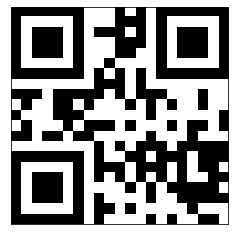

In [88]:

# Codificación

# Prueba de ejemplo:

# Codificación en binario del contenido del mensaje
# ...
mensaje_bits = SecuenciaABits(contenido)
print("Mensaje en bits: ", mensaje_bits)


# Mensaje total= ModeIndicator+CharacterCountIndicator+binaryContenido + relleno
# El mensaje total debe ser una secuencia de enteros no superiores a 255 ni inferiores a 0

MensajeTotal = GeneraCodigo(mensaje_bits)
print("MensajeTotal: ", MensajeTotal)

# Cálculo del FCS: División del mensaje total por el polinomio generador
FCS = CalculoFCS (MensajeTotal)
print("FCS: ", FCS)

# PalabraBloque: Concatenación del mensaje total + FCS
PalabraBloque = CalculoBloque(MensajeTotal, FCS)
print("Palabra de Bloque: ", PalabraBloque)
# Creamos imagen
imagenQR= CreateCanvas(21, colorFondo)


# Colocar los bits de PalabraBloque en la imagen 
imagenQR = DibujaQR(PalabraBloque, imagenQR)
ImprimirImagen(imagenQR)

# Aplicación de la máscara
imagenQR = CalculateMask(imagenQR, colorFondo)



# Mostrar el código QR
ImprimirImagen(imagenQR)
